問題
* 給予文章發佈後前 6 小時的狀態及基本資訊,預測 24 小時後的愛心數

Evaluation
* Mean Absolute Percentage Error (MAPE)

Dataset
* Feature
    - title: 文章標題
    - created_at: 文章發佈時間
    - like_count_1~6h: 文章發佈後 1 到 6 小時的累積愛心數
    - comment_count_1~6h: 文章發佈後 1 到 6 小時的累積留言數
    - forum_id: 文章發佈看板 ID
    - author_id: 文章作者 ID
    - forum_stats: 看板資訊
* Label
    - like_count_24h: 文章發布後 24 小時的累積愛心數

In [1]:
import datetime
import warnings
from collections import Counter

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

pd.set_option('display.max_rows', 30)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)
pd.set_option('display.colheader_justify', 'center')
pd.set_option('display.precision', 2)

sns.set(rc={'figure.figsize':(25, 7)})

train_df = pd.read_csv('intern_homework_train_dataset.csv')

In [2]:
def q1(x):
    return x.quantile(0.25)
def q2(x):
    return x.quantile(0.50) # median
def q3(x):
    return x.quantile(0.75)

def show_values_on_bars(axs):
    def _show_on_single_plot(ax):
        for p in ax.patches:
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + p.get_height()
            value = '{:.2f}'.format(p.get_height())
            ax.text(_x, _y, value, ha="center")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

### 基礎探索

In [3]:
print(f"起訖時間: {min(train_df['created_at'])} ~ {max(train_df['created_at'])}")

起訖時間: 2022-09-01 00:02:34 UTC ~ 2022-10-29 23:59:35 UTC


In [4]:
# no NaN
train_df.isna().sum()

title               0
created_at          0
like_count_1h       0
like_count_2h       0
like_count_3h       0
like_count_4h       0
like_count_5h       0
like_count_6h       0
comment_count_1h    0
comment_count_2h    0
comment_count_3h    0
comment_count_4h    0
comment_count_5h    0
comment_count_6h    0
forum_id            0
author_id           0
forum_stats         0
like_count_24h      0
dtype: int64

In [5]:
train_df.columns

Index(['title', 'created_at', 'like_count_1h', 'like_count_2h', 'like_count_3h', 'like_count_4h', 'like_count_5h', 'like_count_6h', 'comment_count_1h', 'comment_count_2h', 'comment_count_3h', 'comment_count_4h', 'comment_count_5h', 'comment_count_6h', 'forum_id', 'author_id', 'forum_stats', 'like_count_24h'], dtype='object')

### 多 likes 的文特徵長怎樣？

In [6]:
# 先偷看一下前 10 篇
train_df.sort_values(by=['like_count_24h'], ascending=False).head(10)

,title,created_at,like_count_1h,like_count_2h,like_count_3h,like_count_4h,like_count_5h,like_count_6h,comment_count_1h,comment_count_2h,comment_count_3h,comment_count_4h,comment_count_5h,comment_count_6h,forum_id,author_id,forum_stats,like_count_24h
16289,英國女王逝世享耆壽96歲！,2022-09-08 17:55:14 UTC,4044,4797,5098,5362,5822,6588,929,1099,1175,1216,1246,1288,497426,410373,359.8,13297
5686,20歲我得了肺癌四期,2022-10-04 23:37:31 UTC,5,23,223,642,1028,1592,1,5,58,127,189,287,676371,525063,391.4,8935
26951,男友忘記掛電話，讓我聽到噁心事實(已分手封鎖),2022-09-19 12:24:39 UTC,6,9,14,22,41,57,22,29,37,42,45,51,817817,279487,391.7,7588
39049,：牽手走了64年 該放手了（更,2022-09-25 12:30:16 UTC,5,63,357,949,1588,2114,2,15,20,39,91,112,676371,242618,391.4,7084
30193,家裡外勞懷孕了,2022-10-27 10:15:15 UTC,3,16,102,342,723,1134,4,23,56,122,214,326,676371,137747,391.4,5524
33416,三個月前14年閨蜜在我面前上吊，今天我最好的朋友被殺害,2022-10-13 16:00:25 UTC,5,25,44,61,75,100,2,8,13,15,18,23,676371,458917,391.4,5450
35922,回台灣後發現高中同學成了我爸的小情人,2022-10-18 09:00:28 UTC,23,65,226,447,770,1231,22,47,111,177,273,351,676371,357451,391.4,5334
22475,21歲捐肝,2022-09-26 05:11:31 UTC,1,5,18,89,228,506,0,1,6,23,53,94,676371,240874,391.4,5171
48096,＃更 分手後多久可以交下一任,2022-09-01 05:57:15 UTC,5,15,74,242,487,825,2,11,22,43,77,126,817817,714612,391.7,4933
8921,我對奶奶講了很重的話,2022-09-02 06:56:37 UTC,0,0,1,9,43,134,0,0,0,2,8,20,676371,888564,391.4,4903


In [7]:
# 移除 "英國女王逝世享耆壽96歲！" 這篇時事文, 這是突發事件而非其他爆文可參考的文章風格
train_df.drop([16289], axis=0, inplace=True)

In [8]:
# PR75 的文 = 30 顆愛心，跟熱門文章比差異懸殊
train_df['like_count_24h'].describe()

count    49999.00
mean        44.93
std        170.91
min          5.00
25%          7.00
50%         13.00
75%         30.00
max       8935.00
Name: like_count_24h, dtype: float64

In [9]:
# 進一步對 like_counts 做 data binning, 可發現只要 likes > 575 就是 pr99 了
pd.qcut(train_df['like_count_24h'], q=[0, .2, .4, .6, .8, .9, .91, .92, .93, .94, .95, .96, .97, .98, .99], duplicates='drop', retbins=True)

(0        (17.0, 39.0]
 1        (10.0, 17.0]
 2        (17.0, 39.0]
 3        (17.0, 39.0]
 4        (10.0, 17.0]
              ...     
 49995    (10.0, 17.0]
 49996    (4.999, 6.0]
 49997    (10.0, 17.0]
 49998    (10.0, 17.0]
 49999    (4.999, 6.0]
 Name: like_count_24h, Length: 49999, dtype: category
 Categories (14, interval[float64]): [(4.999, 6.0] < (6.0, 10.0] < (10.0, 17.0] < (17.0, 39.0] ... (151.0, 185.0] < (185.0, 240.0] < (240.0, 335.0] < (335.0, 575.0]],
 array([  5.,   6.,  10.,  17.,  39.,  79.,  87.,  97., 111., 128., 151.,
        185., 240., 335., 575.]))

In [50]:
# 更深入的看一下 y，也就是 likes 的分佈
print("-" * 50)
print(f"pencentage of likes >= 2 : {len(train_df[train_df['like_count_24h'] >= 2]) / len(train_df) * 100 :.2f}%")
print(f"pencentage of likes >= 3 : {len(train_df[train_df['like_count_24h'] >= 3]) / len(train_df) * 100 :.2f}%")
print(f"pencentage of likes >= 4 : {len(train_df[train_df['like_count_24h'] >= 4]) / len(train_df) * 100 :.2f}%")
print(f"pencentage of likes >= 5 : {len(train_df[train_df['like_count_24h'] >= 5]) / len(train_df) * 100 :.2f}%")
print(">" * 50)
print(f"pencentage of likes >= 6 : {len(train_df[train_df['like_count_24h'] >= 6]) / len(train_df) * 100 :.2f}%")
print(f"pencentage of likes >= 7 : {len(train_df[train_df['like_count_24h'] >= 7]) / len(train_df) * 100 :.2f}%")
print(f"pencentage of likes >= 8 : {len(train_df[train_df['like_count_24h'] >= 8]) / len(train_df) * 100 :.2f}%")
print(f"pencentage of likes >= 9 : {len(train_df[train_df['like_count_24h'] >= 9]) / len(train_df) * 100 :.2f}%")
print("-" * 50)
print(f"pencentage of likes >= 10 : {len(train_df[train_df['like_count_24h'] >= 10]) / len(train_df) * 100 :.2f}%")
print(">" * 50)
print(f"pencentage of likes >= 20 : {len(train_df[train_df['like_count_24h'] >= 20]) / len(train_df) * 100 :.2f}%")
print(f"pencentage of likes >= 30 : {len(train_df[train_df['like_count_24h'] >= 30]) / len(train_df) * 100 :.2f}%")
print(">" * 50)
print(f"pencentage of likes >= 40 : {len(train_df[train_df['like_count_24h'] >= 40]) / len(train_df) * 100 :.2f}%")
print(f"pencentage of likes >= 50 : {len(train_df[train_df['like_count_24h'] >= 50]) / len(train_df) * 100 :.2f}%")
print(f"pencentage of likes >= 60 : {len(train_df[train_df['like_count_24h'] >= 60]) / len(train_df) * 100 :.2f}%")
print(f"pencentage of likes >= 70 : {len(train_df[train_df['like_count_24h'] >= 70]) / len(train_df) * 100 :.2f}%")
print(f"pencentage of likes >= 80 : {len(train_df[train_df['like_count_24h'] >= 80]) / len(train_df) * 100 :.2f}%")
print(f"pencentage of likes >= 90 : {len(train_df[train_df['like_count_24h'] >= 90]) / len(train_df) * 100 :.2f}%")
print("-" * 50)

--------------------------------------------------
pencentage of likes >= 2 : 100.00%
pencentage of likes >= 3 : 100.00%
pencentage of likes >= 4 : 100.00%
pencentage of likes >= 5 : 100.00%
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
pencentage of likes >= 6 : 88.50%
pencentage of likes >= 7 : 79.69%
pencentage of likes >= 8 : 72.69%
pencentage of likes >= 9 : 66.80%
--------------------------------------------------
pencentage of likes >= 10 : 61.88%
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
pencentage of likes >= 20 : 36.07%
pencentage of likes >= 30 : 25.54%
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
pencentage of likes >= 40 : 19.52%
pencentage of likes >= 50 : 15.84%
pencentage of likes >= 60 : 13.14%
pencentage of likes >= 70 : 11.31%
pencentage of likes >= 80 : 9.87%
pencentage of likes >= 90 : 8.71%
--------------------------------------------------


In [11]:
print("-" * 50)
print(f"pencentage of likes >= 100 : {len(train_df[train_df['like_count_24h'] >= 100]) / len(train_df) * 100 :.2f}%")
print(">" * 50)
print(f"pencentage of likes >= 200 : {len(train_df[train_df['like_count_24h'] >= 200]) / len(train_df) * 100 :.2f}%")
print(f"pencentage of likes >= 300 : {len(train_df[train_df['like_count_24h'] >= 300]) / len(train_df) * 100 :.2f}%")
print(f"pencentage of likes >= 400 : {len(train_df[train_df['like_count_24h'] >= 400]) / len(train_df) * 100 :.2f}%")
print(f"pencentage of likes >= 500 : {len(train_df[train_df['like_count_24h'] >= 500]) / len(train_df) * 100 :.2f}%")
print(">" * 50)
print(f"pencentage of likes >= 600 : {len(train_df[train_df['like_count_24h'] >= 600]) / len(train_df) * 100 :.2f}%")
print(f"pencentage of likes >= 700 : {len(train_df[train_df['like_count_24h'] >= 700]) / len(train_df) * 100 :.2f}%")
print(f"pencentage of likes >= 800 : {len(train_df[train_df['like_count_24h'] >= 800]) / len(train_df) * 100 :.2f}%")
print(f"pencentage of likes >= 900 : {len(train_df[train_df['like_count_24h'] >= 900]) / len(train_df) * 100 :.2f}%")
print(f"pencentage of likes >= 1000 : {len(train_df[train_df['like_count_24h'] >= 1000]) / len(train_df) * 100 :.2f}%")
print("-" * 50)

--------------------------------------------------
pencentage of likes >= 100 : 7.81%
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
pencentage of likes >= 200 : 3.70%
pencentage of likes >= 300 : 2.29%
pencentage of likes >= 400 : 1.59%
pencentage of likes >= 500 : 1.19%
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
pencentage of likes >= 600 : 0.93%
pencentage of likes >= 700 : 0.77%
pencentage of likes >= 800 : 0.63%
pencentage of likes >= 900 : 0.51%
pencentage of likes >= 1000 : 0.43%
--------------------------------------------------


### 看板探索

In [12]:
# PR75 的版瀏覽量 = 93.7
train_df['forum_stats'].describe()

count    49999.00
mean       116.12
std        206.11
min          0.00
25%         16.30
50%         38.00
75%         93.70
max       1128.30
Name: forum_stats, dtype: float64

In [13]:
print(f"總看板數量 total forum numbers: {len(train_df.groupby(['forum_id']).size())}")

總看板數量 total forum numbers: 1147


In [14]:
# 推測 forum_stats 應為看板觀看人次，但是是日或月流量為準就不得而知 (從網頁的 api response 推測應該是月流量)
forum_articles_cnt_df = train_df.groupby(['forum_id', 'forum_stats']).size().to_frame().reset_index().rename({0: "article_count"}, axis=1)

print(f"總看板數量 total forum numbers: {len(forum_articles_cnt_df)}")
forum_articles_cnt_df.head()

總看板數量 total forum numbers: 1148


,forum_id,forum_stats,article_count
0,321,0.0,1
1,2483,0.0,1
2,3013,31.7,373
3,6330,1.0,3
4,6709,0.2,3


In [15]:
# 理論上 forum_id 和 forum_stats 應為 1 對 1 的關係，但為何 group by 兩者的長度是 1148 但 forum_id 只有 1147 ? => 代表 forum_stats 有一個重複值
print(Counter(forum_articles_cnt_df['forum_id']).most_common(1))

[(47568, 2)]


In [16]:
forum_articles_cnt_df[forum_articles_cnt_df['forum_id'] == 47568]

,forum_id,forum_stats,article_count
44,47568,0.1,2
45,47568,18.2,15


In [17]:
print(f"forum_id == 47568 的文章總數: {len(train_df[train_df['forum_id'] == 47568])}")
train_df[train_df['forum_id'] == 47568].head(1)

forum_id == 47568 的文章總數: 17


,title,created_at,like_count_1h,like_count_2h,like_count_3h,like_count_4h,like_count_5h,like_count_6h,comment_count_1h,comment_count_2h,comment_count_3h,comment_count_4h,comment_count_5h,comment_count_6h,forum_id,author_id,forum_stats,like_count_24h
2112,#揪團 克蘭詩禮包揪團～,2022-10-13 14:41:19 UTC,0,0,0,0,0,0,0,0,3,3,3,3,47568,579442,18.2,5


In [18]:
# 少數服從多數，用 18.2 做為 47568 的 forum_stats
train_df['forum_stats'].loc[train_df['forum_id'] == 47568] = 18.2

In [19]:
# 沒有 < 0 的異常值
forum_articles_cnt_df[forum_articles_cnt_df['forum_stats'] < 0]

,forum_id,forum_stats,article_count


In [20]:
# likes 大於 600 已經是 top 1% 的文章，根據 >= 600 的定義超熱門 or 較有可能被推上推薦的看板
likes_above_600_df = train_df[train_df['like_count_24h'] >= 600]

popular_df = likes_above_600_df.groupby(['forum_id', 'forum_stats']).size().to_frame().reset_index().rename({0: "article_count"}, axis=1)

popular_forums_df = forum_articles_cnt_df[forum_articles_cnt_df['forum_id'].isin(popular_df['forum_id'])].sort_values(by=['forum_stats'], ascending=False)
popular_forums = popular_forums_df['forum_id'].to_list()

# 看板人氣
high_views_forums_df = popular_forums_df.sort_values(by=['forum_stats'], ascending=False).head(51)
high_views_forums = high_views_forums_df['forum_id'].to_list()

print(f"熱門看板數量 popular forums count : {len(popular_forums)}")
print(f"有 600 愛心的文章的看板與高瀏覽量的看板的差異 difference between popular and high_views forums: {set(popular_forums) ^ set(high_views_forums)}")
print("-" * 50)
# => 可以知道如果想要 likes > 600 的話一定要發在熱門看板上！
print(popular_forums_df)

熱門看板數量 popular forums count : 51
有 600 愛心的文章的看板與高瀏覽量的看板的差異 difference between popular and high_views forums: set()
--------------------------------------------------
     forum_id  forum_stats  article_count
918   817817      391.7         2531     
759   676371      391.4         2027     
553   497426      359.8         1839     
876   770696      160.6          881     
178   156928      140.1         1841     
..        ...          ...            ...
250   225632        2.4           39     
828   727931        2.2           51     
110    97486        1.0           21     
218   192710        0.4            6     
552   497286        0.1            2     

[51 rows x 3 columns]


In [22]:
# 有各校版的文章，沒有 NSFW 的內容
# train_df[train_df['title'].str.contains("學校")].sort_values(by=['like_count_24h'], ascending=False).head(2)

In [21]:
other_forums = set(train_df['forum_id']) - set(high_views_forums)
other_forums_df = train_df[train_df['forum_id'].isin(list(other_forums))]

# [feature engineering] 將其餘的看板按 quantile 依序設 forum_views_level 值為 3(q3), 2(q2), 1(q1)
train_df['forum_views_level'] = pd.qcut(other_forums_df['forum_stats'], 3, labels=False)

# [feature engineering] 將最熱門的 51 個看板的 forum_views_level 設為 4
train_df.loc[train_df['forum_id'].isin(high_views_forums), 'forum_views_level'] = 4

In [23]:
like_count_6h_cols = ['like_count_1h', 'like_count_2h', 'like_count_3h', 'like_count_4h', 'like_count_5h', 'like_count_6h']
comment_count_6h_cols = ['comment_count_1h', 'comment_count_2h', 'comment_count_3h', 'comment_count_4h', 'comment_count_5h', 'comment_count_6h']

forums_stats_df = train_df.groupby(['forum_id', 'forum_stats']).aggregate({
        k: ['sum', 'mean', 'std'] for k in like_count_6h_cols + comment_count_6h_cols
    }
)

forums_stats_df.columns = ['_'.join(col) for col in forums_stats_df.columns.values] # flatten cols
forums_stats_df.columns = [col + '_in_forum' for col in forums_stats_df.columns if 'forum' not in col] # like_count_1h_sum -> like_count_1h_sum_in_forum
forums_stats_df = forums_stats_df.reset_index().fillna(0)

one_article_forums = forum_articles_cnt_df[forum_articles_cnt_df['article_count'] == 1]['forum_id'].tolist()
print(f"只有一篇文的看版數量: {len(one_article_forums)}, 佔全體看板 {len(one_article_forums) / len(forum_articles_cnt_df) * 100: .3f} %")

forums_stats_df

只有一篇文的看版數量: 398, 佔全體看板  34.669 %


,forum_id,forum_stats,like_count_1h_sum_in_forum,like_count_1h_mean_in_forum,like_count_1h_std_in_forum,like_count_2h_sum_in_forum,like_count_2h_mean_in_forum,like_count_2h_std_in_forum,like_count_3h_sum_in_forum,like_count_3h_mean_in_forum,like_count_3h_std_in_forum,like_count_4h_sum_in_forum,like_count_4h_mean_in_forum,like_count_4h_std_in_forum,like_count_5h_sum_in_forum,like_count_5h_mean_in_forum,like_count_5h_std_in_forum,like_count_6h_sum_in_forum,like_count_6h_mean_in_forum,like_count_6h_std_in_forum,comment_count_1h_sum_in_forum,comment_count_1h_mean_in_forum,comment_count_1h_std_in_forum,comment_count_2h_sum_in_forum,comment_count_2h_mean_in_forum,comment_count_2h_std_in_forum,comment_count_3h_sum_in_forum,comment_count_3h_mean_in_forum,comment_count_3h_std_in_forum,comment_count_4h_sum_in_forum,comment_count_4h_mean_in_forum,comment_count_4h_std_in_forum,comment_count_5h_sum_in_forum,comment_count_5h_mean_in_forum,comment_count_5h_std_in_forum,comment_count_6h_sum_in_forum,comment_count_6h_mean_in_forum,comment_count_6h_std_in_forum
0,321,0.0,5,5.00,0.00,5,5.00,0.00,5,5.00,0.00,6,6.00,0.00,6,6.00,0.00,6,6.00,0.00,37,37.00,0.00,38,38.00,0.00,42,42.00,0.00,47,47.00,0.00,48,48.00,0.00,49,49.00,0.00
1,2483,0.0,5,5.00,0.00,6,6.00,0.00,6,6.00,0.00,8,8.00,0.00,8,8.00,0.00,8,8.00,0.00,0,0.00,0.00,0,0.00,0.00,0,0.00,0.00,1,1.00,0.00,1,1.00,0.00,1,1.00,0.00
2,3013,31.7,1057,2.83,3.85,2000,5.36,6.19,3108,8.33,11.10,4267,11.44,18.84,5434,14.57,28.14,6389,17.13,36.17,808,2.17,3.02,1676,4.49,6.36,2406,6.45,8.97,3176,8.51,12.10,3825,10.25,14.03,4448,11.92,16.35
3,6330,1.0,0,0.00,0.00,0,0.00,0.00,0,0.00,0.00,0,0.00,0.00,0,0.00,0.00,0,0.00,0.00,0,0.00,0.00,0,0.00,0.00,0,0.00,0.00,1,0.33,0.58,6,2.00,3.46,6,2.00,3.46
4,6709,0.2,13,4.33,1.53,17,5.67,1.53,18,6.00,1.00,18,6.00,1.00,21,7.00,2.00,22,7.33,2.08,2,0.67,1.15,2,0.67,1.15,2,0.67,1.15,2,0.67,1.15,2,0.67,1.15,2,0.67,1.15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1142,993253,0.0,5,5.00,0.00,7,7.00,0.00,7,7.00,0.00,7,7.00,0.00,7,7.00,0.00,7,7.00,0.00,1,1.00,0.00,1,1.00,0.00,1,1.00,0.00,1,1.00,0.00,1,1.00,0.00,1,1.00,0.00
1143,994988,40.3,1129,3.70,4.24,1752,5.74,6.00,2444,8.01,8.32,3005,9.85,10.39,3512,11.51,12.56,3926,12.87,14.41,1191,3.90,4.76,1966,6.45,7.18,2718,8.91,9.15,3419,11.21,11.72,3998,13.11,14.61,4368,14.32,16.18
1144,998222,0.3,31,4.43,2.23,40,5.71,3.09,41,5.86,3.08,48,6.86,3.29,52,7.43,3.21,55,7.86,3.34,29,4.14,7.17,39,5.57,9.31,41,5.86,9.65,44,6.29,10.75,74,10.57,21.51,79,11.29,22.98
1145,998313,0.0,11,11.00,0.00,17,17.00,0.00,21,21.00,0.00,22,22.00,0.00,23,23.00,0.00,23,23.00,0.00,0,0.00,0.00,4,4.00,0.00,4,4.00,0.00,4,4.00,0.00,4,4.00,0.00,4,4.00,0.00


In [24]:
# [feature engineering] 加入看板 statistic value
forum_articles_stats_df = forum_articles_cnt_df.merge(forums_stats_df, on=['forum_id', 'forum_stats'], how='inner')
train_df = train_df.merge(forum_articles_stats_df, on=['forum_id', 'forum_stats'], how='inner')

In [25]:
train_df.head(2)

,title,created_at,like_count_1h,like_count_2h,like_count_3h,like_count_4h,like_count_5h,like_count_6h,comment_count_1h,comment_count_2h,comment_count_3h,comment_count_4h,comment_count_5h,comment_count_6h,forum_id,author_id,forum_stats,like_count_24h,forum_views_level,article_count,like_count_1h_sum_in_forum,like_count_1h_mean_in_forum,like_count_1h_std_in_forum,like_count_2h_sum_in_forum,like_count_2h_mean_in_forum,like_count_2h_std_in_forum,like_count_3h_sum_in_forum,like_count_3h_mean_in_forum,like_count_3h_std_in_forum,like_count_4h_sum_in_forum,like_count_4h_mean_in_forum,like_count_4h_std_in_forum,like_count_5h_sum_in_forum,like_count_5h_mean_in_forum,like_count_5h_std_in_forum,like_count_6h_sum_in_forum,like_count_6h_mean_in_forum,like_count_6h_std_in_forum,comment_count_1h_sum_in_forum,comment_count_1h_mean_in_forum,comment_count_1h_std_in_forum,comment_count_2h_sum_in_forum,comment_count_2h_mean_in_forum,comment_count_2h_std_in_forum,comment_count_3h_sum_in_forum,comment_count_3h_mean_in_forum,comment_count_3h_std_in_forum,comment_count_4h_sum_in_forum,comment_count_4h_mean_in_forum,comment_count_4h_std_in_forum,comment_count_5h_sum_in_forum,comment_count_5h_mean_in_forum,comment_count_5h_std_in_forum,comment_count_6h_sum_in_forum,comment_count_6h_mean_in_forum,comment_count_6h_std_in_forum
0,我的排骨湯,2022-10-05 14:20:21 UTC,12,15,15,15,16,18,10,10,10,10,10,10,598518,428921,0.7,26,0.0,21,149,7.1,3.03,195,9.29,3.26,228,10.86,3.2,249,11.86,3.28,266,12.67,3.51,283,13.48,3.71,144,6.86,6.74,168,8.0,6.78,193,9.19,6.94,215,10.24,7.59,217,10.33,7.6,218,10.38,7.53
1,保鮮盒日常-溏心蛋跟茶葉蛋一樣？,2022-10-08 14:16:15 UTC,11,11,11,11,13,13,10,15,15,15,15,15,598518,428921,0.7,18,0.0,21,149,7.1,3.03,195,9.29,3.26,228,10.86,3.2,249,11.86,3.28,266,12.67,3.51,283,13.48,3.71,144,6.86,6.74,168,8.0,6.78,193,9.19,6.94,215,10.24,7.59,217,10.33,7.6,218,10.38,7.53


In [26]:
# def split_over_mean_level(df, col_name, one_article_forums):

#     def _trans_col(x):
#         return x[:-2] + "over_mean_level_" + x[-2:] # like_count_1h -> like_count_over_mean_level_1h

#     over_mean_level_col_name = _trans_col(col_name)

#     '''one article in a month'''
#     one_article_df = df[df['forum_id'].isin(one_article_forums)]
#     one_article_df[over_mean_level_col_name] = 1

#     '''multi articles in a month'''
#     multi_articles_df = df[~df['forum_id'].isin(one_article_forums)]

#     over_mean = (multi_articles_df[col_name] >= multi_articles_df[f'{col_name}_mean_in_forum'])
#     over_1_std = (multi_articles_df[col_name] >= multi_articles_df[f'{col_name}_mean_in_forum'] + 1 * multi_articles_df[f'{col_name}_std_in_forum'])
#     over_2_std = (multi_articles_df[col_name] >= multi_articles_df[f'{col_name}_mean_in_forum'] + 2 * multi_articles_df[f'{col_name}_std_in_forum'])
#     over_3_std = (multi_articles_df[col_name] >= multi_articles_df[f'{col_name}_mean_in_forum'] + 3 * multi_articles_df[f'{col_name}_std_in_forum'])

#     multi_articles_below_mean_df = multi_articles_df[(~over_mean)] # 沒超過該版的 mean 值
#     multi_articles_below_mean_df[over_mean_level_col_name] = 0

#     multi_articles_over_mean_df = multi_articles_df[(over_mean) & (~over_1_std)] # 只超過平均沒有到一個標準差
#     multi_articles_over_mean_df[over_mean_level_col_name] = 1

#     multi_articles_over_1_std_df = multi_articles_df[(over_1_std) & (~over_2_std)] # 只超過一個標準差沒有到兩個標準差
#     multi_articles_over_1_std_df[over_mean_level_col_name] = 2

#     multi_articles_over_2_std_df = multi_articles_df[(over_2_std) & (~over_3_std)] # 只超過兩個標準差沒有到三個標準差
#     multi_articles_over_2_std_df[over_mean_level_col_name] = 3

#     multi_articles_over_3_std_df = multi_articles_df[(over_3_std)] # 超過三個標準差
#     multi_articles_over_3_std_df[over_mean_level_col_name] = 4

#     merged_df = pd.concat([
#         one_article_df, 
#         multi_articles_below_mean_df, multi_articles_over_mean_df, 
#         multi_articles_over_1_std_df, multi_articles_over_2_std_df, multi_articles_over_3_std_df
#     ])

#     over_mean_level = merged_df[over_mean_level_col_name]
#     df[over_mean_level_col_name] = over_mean_level

#     return df

# # [feature engineering] 參考常態分佈的特性給予每個 forum 不同的 level
# for col_name in like_count_6h_cols + comment_count_6h_cols:
#     train_df = split_over_mean_level(train_df, col_name, one_article_forums)

In [27]:
train_df.head(2)

,title,created_at,like_count_1h,like_count_2h,like_count_3h,like_count_4h,like_count_5h,like_count_6h,comment_count_1h,comment_count_2h,comment_count_3h,comment_count_4h,comment_count_5h,comment_count_6h,forum_id,author_id,forum_stats,like_count_24h,forum_views_level,article_count,like_count_1h_sum_in_forum,like_count_1h_mean_in_forum,like_count_1h_std_in_forum,like_count_2h_sum_in_forum,like_count_2h_mean_in_forum,like_count_2h_std_in_forum,like_count_3h_sum_in_forum,like_count_3h_mean_in_forum,like_count_3h_std_in_forum,like_count_4h_sum_in_forum,like_count_4h_mean_in_forum,like_count_4h_std_in_forum,like_count_5h_sum_in_forum,like_count_5h_mean_in_forum,like_count_5h_std_in_forum,like_count_6h_sum_in_forum,like_count_6h_mean_in_forum,like_count_6h_std_in_forum,comment_count_1h_sum_in_forum,comment_count_1h_mean_in_forum,comment_count_1h_std_in_forum,comment_count_2h_sum_in_forum,comment_count_2h_mean_in_forum,comment_count_2h_std_in_forum,comment_count_3h_sum_in_forum,comment_count_3h_mean_in_forum,comment_count_3h_std_in_forum,comment_count_4h_sum_in_forum,comment_count_4h_mean_in_forum,comment_count_4h_std_in_forum,comment_count_5h_sum_in_forum,comment_count_5h_mean_in_forum,comment_count_5h_std_in_forum,comment_count_6h_sum_in_forum,comment_count_6h_mean_in_forum,comment_count_6h_std_in_forum
0,我的排骨湯,2022-10-05 14:20:21 UTC,12,15,15,15,16,18,10,10,10,10,10,10,598518,428921,0.7,26,0.0,21,149,7.1,3.03,195,9.29,3.26,228,10.86,3.2,249,11.86,3.28,266,12.67,3.51,283,13.48,3.71,144,6.86,6.74,168,8.0,6.78,193,9.19,6.94,215,10.24,7.59,217,10.33,7.6,218,10.38,7.53
1,保鮮盒日常-溏心蛋跟茶葉蛋一樣？,2022-10-08 14:16:15 UTC,11,11,11,11,13,13,10,15,15,15,15,15,598518,428921,0.7,18,0.0,21,149,7.1,3.03,195,9.29,3.26,228,10.86,3.2,249,11.86,3.28,266,12.67,3.51,283,13.48,3.71,144,6.86,6.74,168,8.0,6.78,193,9.19,6.94,215,10.24,7.59,217,10.33,7.6,218,10.38,7.53


In [28]:
# like 數與 comment 數的相關性 ? (Pearson Correlation)
target_col = ['like_count_24h']

print(f"like_count    | comment_count    |  corr")
print('- - - - - - - - - - - - - - - - - - - - -')

for like_col, comment_col in zip(like_count_6h_cols, comment_count_6h_cols):
    corr = train_df[like_col].corr(train_df[comment_col])
    print(f"{like_col} | {comment_col} | {corr: .3f}")


like_count    | comment_count    |  corr
- - - - - - - - - - - - - - - - - - - - -
like_count_1h | comment_count_1h |  0.080
like_count_2h | comment_count_2h |  0.088
like_count_3h | comment_count_3h |  0.096
like_count_4h | comment_count_4h |  0.104
like_count_5h | comment_count_5h |  0.111
like_count_6h | comment_count_6h |  0.116


### 發文的良辰吉日

In [29]:
# 取得發文時間是一週的第幾天
train_df['post_weekday'] = train_df['created_at'].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S %Z").strftime('%A'))

[Text(0.5, 1.0, 'Total articles counts in weekdays')]

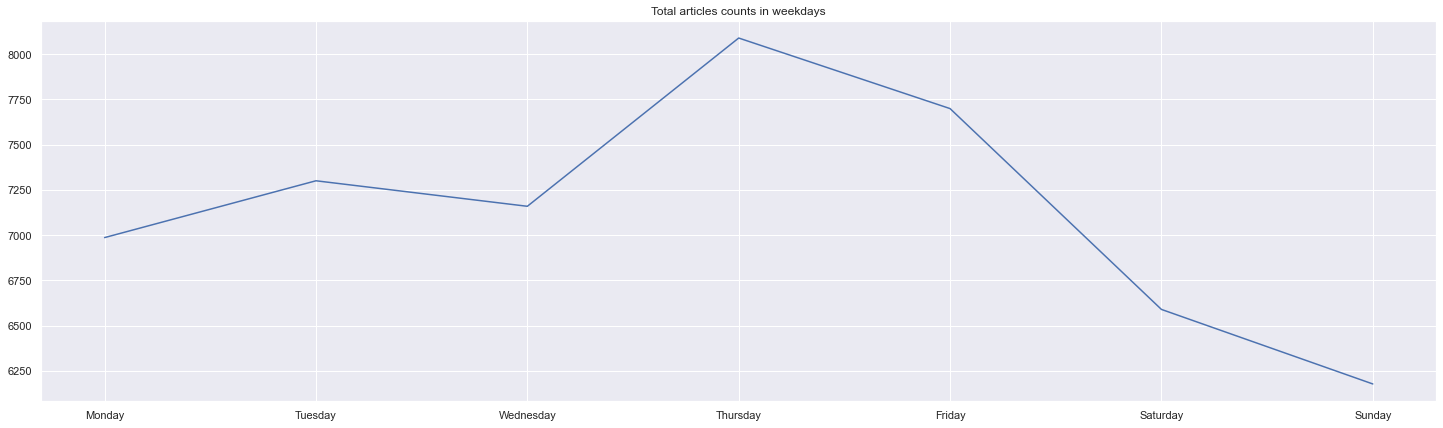

In [30]:
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

total_article_count_in_weekday = train_df['post_weekday'].value_counts().reindex(weekday_order) # 一~日的總發文篇數
sns.lineplot(x=total_article_count_in_weekday.index, y=total_article_count_in_weekday.values).set(title='Total articles counts in weekdays')

In [31]:
# 計算 like_count_{1~6}h with weekday 的 statistic values
weekday_stats_df = train_df[like_count_6h_cols + ['post_weekday']].groupby(['post_weekday']).aggregate([q1, q2, q3, 'mean', 'std']).reindex(weekday_order)
weekday_stats_df

like_count_1h                   like_count_2h                    like_count_3h                    like_count_4h                     like_count_5h                      like_count_6h                     
                   q1      q2 q3  mean  std        q1      q2 q3  mean  std         q1      q2 q3  mean  std         q1      q2 q3  mean   std         q1      q2  q3  mean   std         q1      q2  q3  mean   std  
post_weekday                                                                                                                                                                                                          
Monday              0       1  3  2.97  6.38        1       3  5  4.97  11.20        2       4  7  7.31  16.69        2       4  9   9.82  22.91        3       5  11  12.25  29.72        3       6  12  14.44  36.63
Tuesday             0       1  3  2.93  7.04        1       2  5  4.89  11.27        2       4  7  7.14  16.41        2       4  9   9.58  23.70        3       5  10  11.95  32.15        3       6  12  14.22  42.31
Wednesday           0       1  3  3.01  7.03        1       3  5  5.06  12.68        2       4  7  7.34  19.00        2       5  9   9.74  26.38        3       5  10  12.08  33.85        3       6  12  14.23  41.36
Thursday            0       1  3  3.06  6.34        1       3  5  5.21  11.90        2       4  7  7.70  19.15        2       5  9  10.28  27.17        3       5  10  12.75  36.03        3       6  12  15.10  45.34
Friday              0       1  3  3.18  7.77        1       3  5  5.47  13.29        2       4  7  8.06  20.28        2       5  9  10.71  28.02        3       5  11  13.22  35.66        3       6  12  15.47  43.07
Saturday            0       1  3  2.86  5.95        1       2  5  5.05  11.94        2       4  7  7.66  19.32        2       4  9  10.40  27.27        3       5  11  13.08  35.61        3       6  12  15.59  44.46
Sunday              0       1  3  3.08  6.00        1       3  5  5.22  10.58        2       4  7  7.75  16.93        2       5  9  10.48  26.17        3       5  11  13.04  36.38        3       6  13  15.43  46.40

In [32]:
diff_cols = []

weekday_stats_df.columns = ['_'.join(col) for col in weekday_stats_df.columns.values] # flatten cols
weekday_stats_df.columns = [col + '_in_weekday' for col in weekday_stats_df.columns if 'weekday' not in col] # like_count_1h_sum -> like_count_1h_sum_in_forum

for in_weekday_col in weekday_stats_df.columns:
    if len(set(weekday_stats_df[in_weekday_col])) > 1: # 有不一樣再畫圖比較
        diff_cols.append(in_weekday_col)

diff_cols

['like_count_1h_mean_in_weekday',
 'like_count_1h_std_in_weekday',
 'like_count_2h_q2_in_weekday',
 'like_count_2h_mean_in_weekday',
 'like_count_2h_std_in_weekday',
 'like_count_3h_mean_in_weekday',
 'like_count_3h_std_in_weekday',
 'like_count_4h_q2_in_weekday',
 'like_count_4h_mean_in_weekday',
 'like_count_4h_std_in_weekday',
 'like_count_5h_q3_in_weekday',
 'like_count_5h_mean_in_weekday',
 'like_count_5h_std_in_weekday',
 'like_count_6h_q3_in_weekday',
 'like_count_6h_mean_in_weekday',
 'like_count_6h_std_in_weekday']

---Mean difference between weekdays---


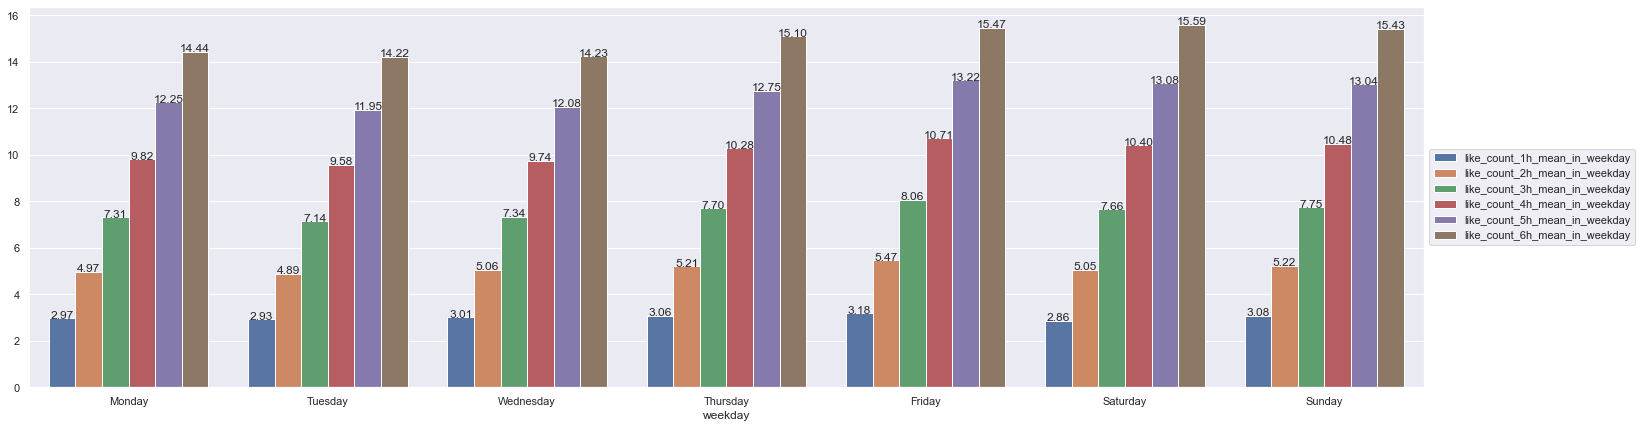

---std difference between weekdays---


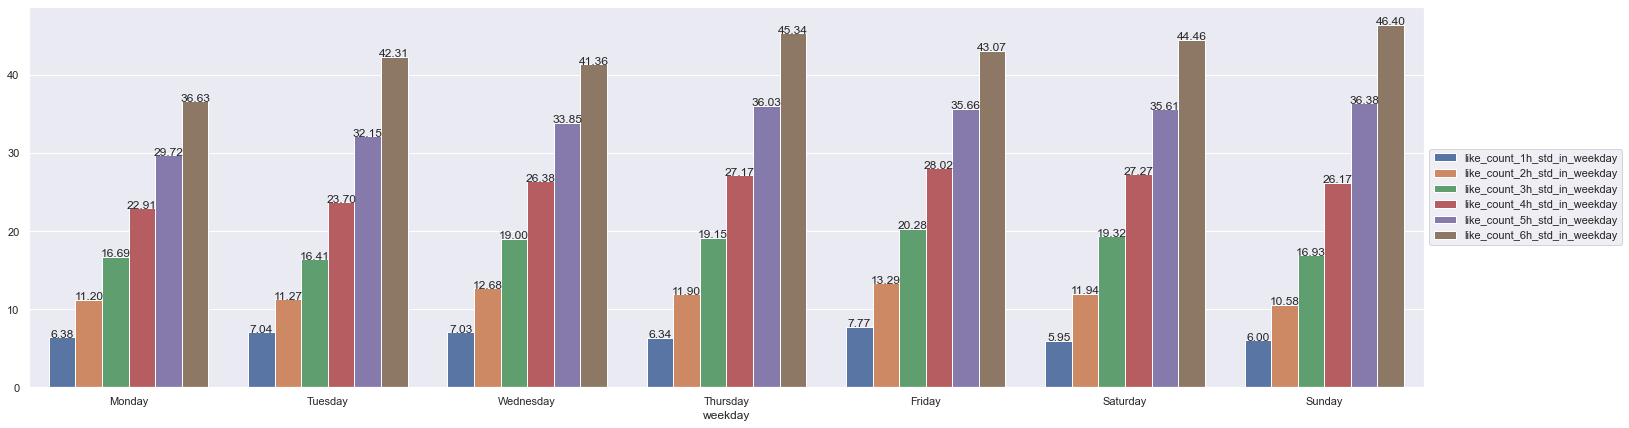

---Q2 difference between weekdays---


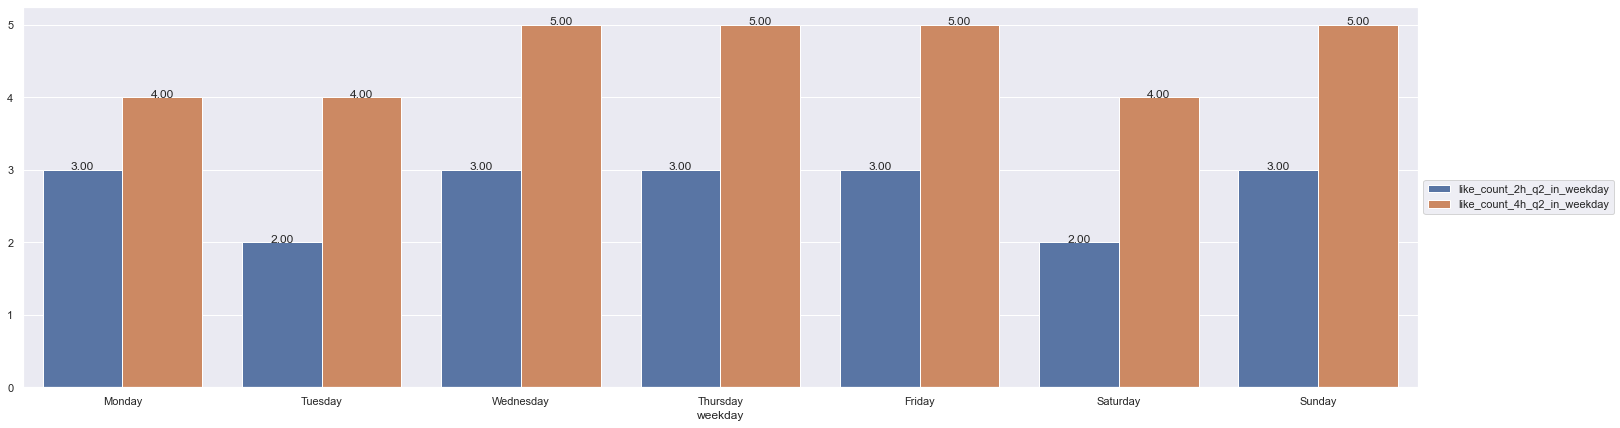

---Q3 difference between weekdays---


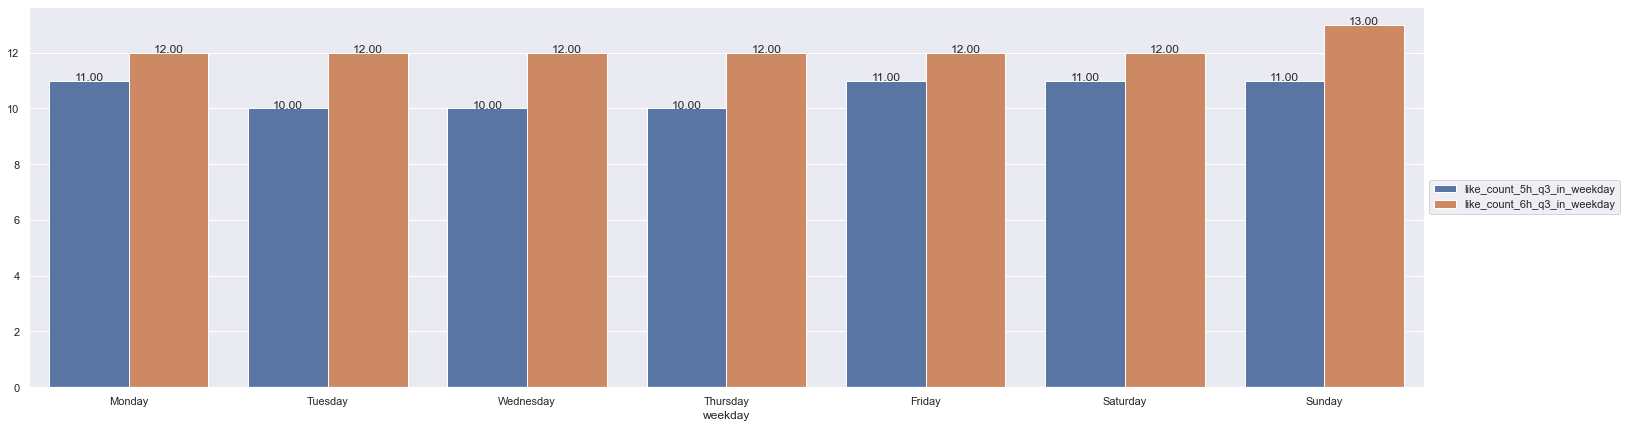

In [33]:
sdf = weekday_stats_df[diff_cols].reset_index()
sdf = sdf.melt(id_vars="post_weekday", var_name="col_statistic_values")

sdf_mean = sdf[sdf['col_statistic_values'].str.contains("mean")]
sdf_std = sdf[sdf['col_statistic_values'].str.contains("std")]
sdf_q2 = sdf[sdf['col_statistic_values'].str.contains("q2")]
sdf_q3 = sdf[sdf['col_statistic_values'].str.contains("q3")]

def visualize_weekday_diff(sdf):
    ax = sns.barplot(x="post_weekday", y="value", hue="col_statistic_values", data=sdf)
    ax.set(ylabel="", xlabel="weekday")
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    show_values_on_bars(ax)
    plt.show()

print('---Mean difference between weekdays---')
visualize_weekday_diff(sdf_mean)
print('---std difference between weekdays---')
visualize_weekday_diff(sdf_std)
print('---Q2 difference between weekdays---')
visualize_weekday_diff(sdf_q2)
print('---Q3 difference between weekdays---')
visualize_weekday_diff(sdf_q3)

### 發文的良辰吉時

In [34]:
# 取得發文時間
train_df['post_hour'] = train_df['created_at'].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S %Z").hour)

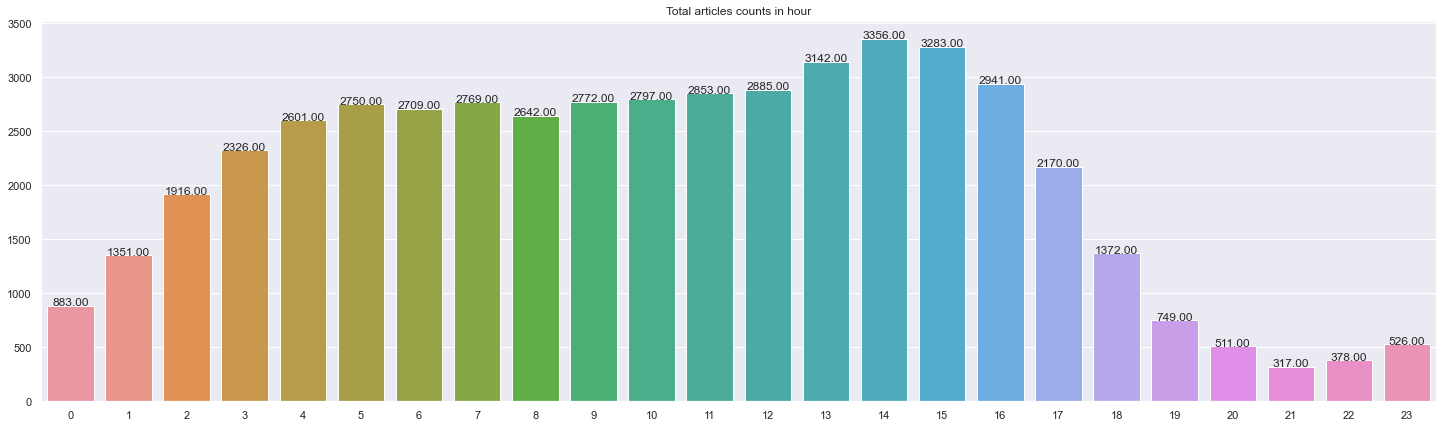

In [35]:
total_article_count_in_hour = train_df['post_hour'].value_counts().sort_index() # 各時間點的總發文篇數

ax = sns.barplot(x=total_article_count_in_hour.index, y=total_article_count_in_hour.values)
ax.set(title='Total articles counts in hour')
show_values_on_bars(ax)

# => 下午文章比上午多，下班時間(18~21點)文章數量激減，凌晨不睡覺(1~6點)在發文的人意外的非常多

In [36]:
post_timing = ['post_weekday', 'post_hour']

def get_stats_df(df, col_suffix, sort_by_like_cnt):
    '''
    parameters:
        df : pd.DataFrame
        col_suffix : the suffix that you wants to be add after aggregated column names
        sort_by_like_cnt : 是否根據綜合的 like_count 排序
    return:
        flatten_df : flatten df
    '''
    df.columns = ['_'.join(col) for col in df.columns.values] # flatten cols
    df.columns = [col + col_suffix for col in df.columns if 'like' in col] # like_count_1h_sum -> like_count_1h_sum_in_weekday_hour

    df.reset_index(inplace=True)

    if sort_by_like_cnt:
        like_count_cols_in_col_suffix = [c for c in df.columns if 'like' in c]
        flatten_df = df.sort_values(like_count_cols_in_col_suffix, ascending=False)
    else:
        pass

    return flatten_df

col_suffix = '_in_weekday_hour'
sort_by_like_cnt = True

# 根據 like_count_24h 切分 8:2
PR80_like_count = train_df['like_count_24h'].quantile(0.8)

train_df_below_PR80 = train_df[train_df['like_count_24h'] <= PR80_like_count] # 普通的文章
train_df_over_PR80 = train_df[train_df['like_count_24h'] > PR80_like_count] # 特別紅的文章

post_timing_stats_df = train_df[like_count_6h_cols + post_timing].groupby(post_timing).aggregate([q1, q2, q3, 'mean', 'std'])

# below PR80
post_timing_stats_below_PR80_df = train_df_below_PR80[like_count_6h_cols + post_timing].groupby(post_timing).aggregate([q1, q2, q3, 'mean', 'std'])
post_timing_stats_below_PR80_df = get_stats_df(post_timing_stats_below_PR80_df, col_suffix, sort_by_like_cnt)

# over PR80
post_timing_stats_over_PR80_df = train_df_over_PR80[like_count_6h_cols + post_timing].groupby(post_timing).aggregate([q1, q2, q3, 'mean', 'std'])
post_timing_stats_over_PR80_df = get_stats_df(post_timing_stats_over_PR80_df, col_suffix, sort_by_like_cnt)

In [37]:
post_timing_stats_below_PR80_df

,post_weekday,post_hour,like_count_1h_q1_in_weekday_hour,like_count_1h_q2_in_weekday_hour,like_count_1h_q3_in_weekday_hour,like_count_1h_mean_in_weekday_hour,like_count_1h_std_in_weekday_hour,like_count_2h_q1_in_weekday_hour,like_count_2h_q2_in_weekday_hour,like_count_2h_q3_in_weekday_hour,like_count_2h_mean_in_weekday_hour,like_count_2h_std_in_weekday_hour,like_count_3h_q1_in_weekday_hour,like_count_3h_q2_in_weekday_hour,like_count_3h_q3_in_weekday_hour,like_count_3h_mean_in_weekday_hour,like_count_3h_std_in_weekday_hour,like_count_4h_q1_in_weekday_hour,like_count_4h_q2_in_weekday_hour,like_count_4h_q3_in_weekday_hour,like_count_4h_mean_in_weekday_hour,like_count_4h_std_in_weekday_hour,like_count_5h_q1_in_weekday_hour,like_count_5h_q2_in_weekday_hour,like_count_5h_q3_in_weekday_hour,like_count_5h_mean_in_weekday_hour,like_count_5h_std_in_weekday_hour,like_count_6h_q1_in_weekday_hour,like_count_6h_q2_in_weekday_hour,like_count_6h_q3_in_weekday_hour,like_count_6h_mean_in_weekday_hour,like_count_6h_std_in_weekday_hour
61,Saturday,13,1.0,2.0,4.0,2.32,2.45,1.0,3.0,5.0,3.55,3.19,2.00,4.0,7.0,4.97,3.87,3.0,5.0,8.00,6.01,4.54,3.0,5.0,9.00,6.78,5.06,4.0,6.0,10.00,7.14,5.25
111,Thursday,15,1.0,2.0,3.0,2.43,2.68,1.0,3.0,5.0,3.33,3.18,1.00,3.0,6.0,4.02,3.68,2.0,4.0,6.00,4.48,3.90,2.0,4.0,6.50,4.69,4.00,2.0,4.0,7.00,4.81,4.03
86,Sunday,14,1.0,2.0,3.0,2.41,2.58,1.0,3.0,5.0,3.60,3.31,2.00,4.0,6.0,4.58,4.15,2.0,4.0,6.00,5.30,4.68,2.5,5.0,7.00,5.65,4.94,3.0,5.0,7.00,5.82,5.01
38,Monday,14,1.0,2.0,3.0,2.39,2.55,1.0,3.0,5.0,3.65,3.22,2.00,4.0,6.0,4.76,3.95,2.0,4.0,7.00,5.49,4.45,3.0,5.0,8.00,5.88,4.73,3.0,5.0,8.00,6.09,4.84
159,Wednesday,15,1.0,2.0,3.0,2.37,2.42,1.0,3.0,5.0,3.40,3.01,2.00,3.0,6.0,4.18,3.46,2.0,4.0,6.00,4.58,3.69,2.0,4.0,7.00,4.80,3.82,2.0,4.0,7.00,4.91,3.87
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93,Sunday,21,0.0,0.0,1.0,0.63,1.15,0.0,1.0,2.0,1.21,1.68,0.00,1.0,3.0,1.92,2.56,1.0,2.0,3.00,2.55,3.02,2.0,3.0,4.00,3.58,3.55,2.0,3.5,6.00,4.74,4.40
44,Monday,20,0.0,0.0,1.0,0.62,0.91,0.0,0.5,1.0,0.85,1.15,0.00,1.0,2.0,1.29,1.58,1.0,1.0,3.00,2.29,2.58,1.0,2.0,4.00,3.00,2.91,1.0,2.0,5.00,3.54,3.34
45,Monday,21,0.0,0.0,1.0,0.59,1.12,0.0,0.0,1.0,0.74,1.13,0.00,1.0,3.0,1.70,1.59,1.0,2.0,4.00,2.78,2.14,2.0,4.0,5.00,4.00,2.96,2.0,4.0,6.00,4.59,3.61
69,Saturday,21,0.0,0.0,1.0,0.43,0.62,0.0,0.0,1.0,0.63,0.80,0.00,1.0,2.0,1.20,1.36,1.0,2.0,3.00,1.98,1.79,1.0,2.0,4.75,2.87,2.66,2.0,3.5,5.75,3.89,3.03


In [38]:
post_timing_stats_over_PR80_df

,post_weekday,post_hour,like_count_1h_q1_in_weekday_hour,like_count_1h_q2_in_weekday_hour,like_count_1h_q3_in_weekday_hour,like_count_1h_mean_in_weekday_hour,like_count_1h_std_in_weekday_hour,like_count_2h_q1_in_weekday_hour,like_count_2h_q2_in_weekday_hour,like_count_2h_q3_in_weekday_hour,like_count_2h_mean_in_weekday_hour,like_count_2h_std_in_weekday_hour,like_count_3h_q1_in_weekday_hour,like_count_3h_q2_in_weekday_hour,like_count_3h_q3_in_weekday_hour,like_count_3h_mean_in_weekday_hour,like_count_3h_std_in_weekday_hour,like_count_4h_q1_in_weekday_hour,like_count_4h_q2_in_weekday_hour,like_count_4h_q3_in_weekday_hour,like_count_4h_mean_in_weekday_hour,like_count_4h_std_in_weekday_hour,like_count_5h_q1_in_weekday_hour,like_count_5h_q2_in_weekday_hour,like_count_5h_q3_in_weekday_hour,like_count_5h_mean_in_weekday_hour,like_count_5h_std_in_weekday_hour,like_count_6h_q1_in_weekday_hour,like_count_6h_q2_in_weekday_hour,like_count_6h_q3_in_weekday_hour,like_count_6h_mean_in_weekday_hour,like_count_6h_std_in_weekday_hour
59,Saturday,11,3.0,6.0,12.0,11.38,17.49,6.75,10.5,23.75,23.53,36.73,12.75,19.0,35.00,38.96,57.87,17.75,27.0,46.00,55.32,79.33,22.75,32.0,58.25,72.62,102.11,26.75,37.5,65.00,86.66,124.49
109,Thursday,13,2.0,6.0,14.0,13.24,21.59,5.25,12.0,28.00,27.17,41.61,11.50,20.5,47.75,48.23,71.37,17.00,29.5,62.00,66.24,101.80,20.00,34.5,68.50,78.22,123.56,20.00,36.0,78.00,84.73,135.52
8,Friday,8,2.0,6.0,12.5,11.16,16.01,6.00,12.0,24.00,19.95,28.46,11.00,18.0,31.50,32.22,58.23,18.00,27.0,43.50,46.30,91.71,22.00,34.0,50.50,60.75,126.76,28.00,40.0,64.50,76.03,164.22
134,Tuesday,14,2.0,6.0,12.0,13.73,38.50,4.00,9.0,18.50,21.23,48.82,6.00,17.0,27.00,27.89,54.66,8.00,19.0,33.50,32.84,58.44,9.00,20.0,35.00,35.55,60.12,10.00,22.0,36.00,37.00,60.65
156,Wednesday,12,2.0,6.0,11.0,10.22,15.21,4.00,11.0,19.00,18.66,26.38,10.00,19.0,34.00,31.32,47.04,16.00,26.0,48.00,47.62,79.23,22.00,31.0,71.00,61.40,108.64,24.00,35.0,73.00,69.26,129.41
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21,Friday,21,0.0,1.0,1.0,0.67,0.71,1.00,1.0,2.00,1.56,1.33,2.00,3.0,3.00,3.78,4.58,2.00,6.0,9.00,8.56,11.82,5.00,6.0,17.00,14.44,18.27,8.00,10.0,25.00,22.78,29.32
94,Sunday,22,0.0,0.5,2.0,1.33,2.27,1.00,2.0,4.25,3.42,3.99,1.00,4.5,7.50,5.75,6.28,3.75,7.0,14.50,10.50,9.24,6.75,10.5,26.75,16.58,13.86,8.75,15.0,31.25,20.92,16.16
117,Thursday,21,0.0,0.0,2.0,1.14,1.57,1.00,2.0,6.00,6.71,11.00,1.50,3.0,11.00,12.00,19.54,2.50,8.0,30.00,23.29,31.63,5.00,12.0,55.00,36.43,44.11,13.00,16.0,89.00,53.57,57.45
69,Saturday,21,0.0,0.0,1.0,1.22,2.02,1.00,1.0,2.00,2.56,3.90,1.00,2.0,3.75,4.50,6.49,3.25,5.5,9.25,8.50,9.53,6.00,8.0,18.50,14.83,15.92,8.25,14.5,30.00,22.72,22.18


In [39]:
bin_nums = 4
bin_ranks = [4, 3, 2, 1]

def get_rank_level(df_len, bin_nums, bin_ranks):
    rank_level = []

    for rank in bin_ranks:
        rank_level.extend([rank] * int(df_len / bin_nums))

    return rank_level

# [feature engineering] 依據 like_count 排 level, 1 ~ 4
post_timing_stats_below_PR80_df['post_timing_below_PR80_level'] = get_rank_level(
    len(post_timing_stats_below_PR80_df), bin_nums, bin_ranks
)
post_timing_stats_over_PR80_df['post_timing_over_PR80_level'] = get_rank_level(
    len(post_timing_stats_over_PR80_df), bin_nums, bin_ranks
)

In [40]:
# [feature engineering] 根據發文時間加入 post_timing_below_PR80_level、post_timing_over_PR80_level
post_timing_level_df = post_timing_stats_below_PR80_df[post_timing + ['post_timing_below_PR80_level']].merge(
    post_timing_stats_over_PR80_df[post_timing + ['post_timing_over_PR80_level']], on=post_timing, how='inner'
)
train_df = train_df.merge(post_timing_level_df, on=post_timing, how='inner')

In [41]:
train_df.head(2)

,title,created_at,like_count_1h,like_count_2h,like_count_3h,like_count_4h,like_count_5h,like_count_6h,comment_count_1h,comment_count_2h,comment_count_3h,comment_count_4h,comment_count_5h,comment_count_6h,forum_id,author_id,forum_stats,like_count_24h,forum_views_level,article_count,like_count_1h_sum_in_forum,like_count_1h_mean_in_forum,like_count_1h_std_in_forum,like_count_2h_sum_in_forum,like_count_2h_mean_in_forum,like_count_2h_std_in_forum,like_count_3h_sum_in_forum,like_count_3h_mean_in_forum,like_count_3h_std_in_forum,like_count_4h_sum_in_forum,like_count_4h_mean_in_forum,like_count_4h_std_in_forum,like_count_5h_sum_in_forum,like_count_5h_mean_in_forum,like_count_5h_std_in_forum,like_count_6h_sum_in_forum,like_count_6h_mean_in_forum,like_count_6h_std_in_forum,comment_count_1h_sum_in_forum,comment_count_1h_mean_in_forum,comment_count_1h_std_in_forum,comment_count_2h_sum_in_forum,comment_count_2h_mean_in_forum,comment_count_2h_std_in_forum,comment_count_3h_sum_in_forum,comment_count_3h_mean_in_forum,comment_count_3h_std_in_forum,comment_count_4h_sum_in_forum,comment_count_4h_mean_in_forum,comment_count_4h_std_in_forum,comment_count_5h_sum_in_forum,comment_count_5h_mean_in_forum,comment_count_5h_std_in_forum,comment_count_6h_sum_in_forum,comment_count_6h_mean_in_forum,comment_count_6h_std_in_forum,post_weekday,post_hour,post_timing_below_PR80_level,post_timing_over_PR80_level
0,我的排骨湯,2022-10-05 14:20:21 UTC,12,15,15,15,16,18,10,10,10,10,10,10,598518,428921,0.7,26,0.0,21,149,7.1,3.03,195,9.29,3.26,228,10.86,3.2,249,11.86,3.28,266,12.67,3.51,283,13.48,3.71,144,6.86,6.74,168,8.0,6.78,193,9.19,6.94,215,10.24,7.59,217,10.33,7.6,218,10.38,7.53,Wednesday,14,4,4
1,跟大家介紹一下這是我老婆,2022-09-28 14:11:34 UTC,9,12,14,16,17,17,26,27,27,27,27,27,598518,428921,0.7,27,0.0,21,149,7.1,3.03,195,9.29,3.26,228,10.86,3.2,249,11.86,3.28,266,12.67,3.51,283,13.48,3.71,144,6.86,6.74,168,8.0,6.78,193,9.19,6.94,215,10.24,7.59,217,10.33,7.6,218,10.38,7.53,Wednesday,14,4,4


### 特定作者的影響

In [42]:
target_y = ['like_count_24h']
analysis_aspect = ['author_id']

col_suffix = '_in_authors'
sort_by_like_cnt = True

selected_df = train_df[like_count_6h_cols + target_y + analysis_aspect]
author_articles_cnt_df = selected_df.groupby(analysis_aspect).size().to_frame().reset_index().rename({0: "article_count"}, axis=1) # 各作者發文篇數

one_articles_authors = author_articles_cnt_df[author_articles_cnt_df['article_count'] == 1]['author_id'].to_list()
multi_articles_authors = author_articles_cnt_df[author_articles_cnt_df['article_count'] > 1]['author_id'].to_list()

one_articles_authors_df = train_df[train_df['author_id'].isin(one_articles_authors)]
multi_articles_authors_df = train_df[train_df['author_id'].isin(multi_articles_authors)]

multi_articles_authors_selected_df = multi_articles_authors_df[like_count_6h_cols + target_y + analysis_aspect]

multi_articles_authors_stats_selected_df = multi_articles_authors_selected_df.groupby(analysis_aspect).aggregate(['mean', 'std'])
multi_articles_authors_stats_selected_df = get_stats_df(multi_articles_authors_stats_selected_df, col_suffix, sort_by_like_cnt)


In [43]:
print(f"只發一篇的作者: {len(one_articles_authors)} 位，佔總文章比例 {len(one_articles_authors)/len(train_df) * 100: .3f}%")
print(f"發多篇的作者: {len(multi_articles_authors)} 位，佔總文章比例 {(1-len(one_articles_authors)/len(train_df)) * 100: .3f}%，平均一人發 {(len(train_df) - len(one_articles_authors)) / len(multi_articles_authors): .3f} 篇文")

只發一篇的作者: 25323 位，佔總文章比例  50.647%
發多篇的作者: 6957 位，佔總文章比例  49.353%，平均一人發  3.547 篇文


In [44]:
multi_articles_authors_df = author_articles_cnt_df[author_articles_cnt_df[analysis_aspect[0]].isin(multi_articles_authors)]
multi_articles_authors_stats_cnt_selected_df = multi_articles_authors_df.merge(multi_articles_authors_stats_selected_df, on=analysis_aspect, how='inner')

In [45]:
# [feature engineering] 頂尖創作者 (多篇作者中的平均 like 有 PR75 以上)
binning = pd.qcut(multi_articles_authors_stats_cnt_selected_df['like_count_24h_mean_in_authors'], 4, labels=False)
binning = list(map(lambda x: 1 if x >= 3 else 0, binning))
multi_articles_authors_stats_cnt_selected_df['top_author_in_authors'] = binning

# [feature engineering] 高 like 作者 (mean 高於所有文章的 like 平均)
all_train_median = train_df[target_y].quantile(0.5).values[0]

hot_popularity_authors_df = multi_articles_authors_stats_cnt_selected_df[multi_articles_authors_stats_cnt_selected_df['like_count_24h_mean_in_authors'] >= all_train_median]
low_popularity_authors_df = multi_articles_authors_stats_cnt_selected_df[multi_articles_authors_stats_cnt_selected_df['like_count_24h_mean_in_authors'] < all_train_median]

hot_popularity_authors_df['like_count_popularity_level_in_authors'] = 1
low_popularity_authors_df['like_count_popularity_level_in_authors'] = 0

multi_articles_authors_stats_cnt_selected_df = pd.concat([hot_popularity_authors_df, low_popularity_authors_df], axis=0)

# [feature engineering] 高爆發力作者，根據作者的 std 做 binning
# 若 std_mean_ratio 越大代表該 std 相對該 author 來說越大
total_std = multi_articles_authors_stats_cnt_selected_df['like_count_1h_std_in_authors'] + multi_articles_authors_stats_cnt_selected_df['like_count_2h_std_in_authors'] + \
multi_articles_authors_stats_cnt_selected_df['like_count_3h_std_in_authors'] + multi_articles_authors_stats_cnt_selected_df['like_count_4h_std_in_authors'] + \
multi_articles_authors_stats_cnt_selected_df['like_count_5h_std_in_authors'] + multi_articles_authors_stats_cnt_selected_df['like_count_6h_std_in_authors'] + \
multi_articles_authors_stats_cnt_selected_df['like_count_24h_std_in_authors']

total_mean = multi_articles_authors_stats_cnt_selected_df['like_count_1h_mean_in_authors'] + multi_articles_authors_stats_cnt_selected_df['like_count_2h_mean_in_authors'] + \
multi_articles_authors_stats_cnt_selected_df['like_count_3h_mean_in_authors'] + multi_articles_authors_stats_cnt_selected_df['like_count_4h_mean_in_authors'] + \
multi_articles_authors_stats_cnt_selected_df['like_count_5h_mean_in_authors'] + multi_articles_authors_stats_cnt_selected_df['like_count_6h_mean_in_authors'] + \
multi_articles_authors_stats_cnt_selected_df['like_count_24h_mean_in_authors']

std_mean_ratio = total_std / total_mean

multi_articles_authors_stats_cnt_selected_df['like_count_std_ratio_level_in_authors'] = pd.qcut(std_mean_ratio, 4, labels=False)

# [feature engineering] 發文狂魔 (article_count 高)
multi_articles_median = multi_articles_authors_stats_cnt_selected_df['article_count'].quantile(0.5)
post_lovers = multi_articles_authors_stats_cnt_selected_df[multi_articles_authors_stats_cnt_selected_df['article_count'] > multi_articles_median]['author_id']

post_lovers_df = multi_articles_authors_stats_cnt_selected_df[multi_articles_authors_stats_cnt_selected_df['author_id'].isin(post_lovers)]
not_post_lovers_df = multi_articles_authors_stats_cnt_selected_df[~multi_articles_authors_stats_cnt_selected_df['author_id'].isin(post_lovers)]

post_lovers_df['post_lovers_in_authors'] = 1
not_post_lovers_df['post_lovers_in_authors'] = 0

multi_articles_authors_stats_cnt_selected_df = pd.concat([post_lovers_df, not_post_lovers_df], axis=0)

# 只有一篇的作者不做處理
one_articles_authors_df['top_author_in_authors'] = 0
one_articles_authors_df['like_count_popularity_level_in_authors'] = 0
one_articles_authors_df['like_count_std_ratio_level_in_authors'] = 0
one_articles_authors_df['post_lovers_in_authors'] = 0

selected_cols = ['author_id', 'top_author_in_authors', 'like_count_popularity_level_in_authors', 'like_count_std_ratio_level_in_authors', 'post_lovers_in_authors']
authors_df = pd.concat([multi_articles_authors_stats_cnt_selected_df[selected_cols], one_articles_authors_df[selected_cols]], axis=0)

train_df = train_df.merge(authors_df, on='author_id', how='inner')

In [46]:
train_df.head(2)

,title,created_at,like_count_1h,like_count_2h,like_count_3h,like_count_4h,like_count_5h,like_count_6h,comment_count_1h,comment_count_2h,comment_count_3h,comment_count_4h,comment_count_5h,comment_count_6h,forum_id,author_id,forum_stats,like_count_24h,forum_views_level,article_count,like_count_1h_sum_in_forum,like_count_1h_mean_in_forum,like_count_1h_std_in_forum,like_count_2h_sum_in_forum,like_count_2h_mean_in_forum,like_count_2h_std_in_forum,like_count_3h_sum_in_forum,like_count_3h_mean_in_forum,like_count_3h_std_in_forum,like_count_4h_sum_in_forum,like_count_4h_mean_in_forum,like_count_4h_std_in_forum,like_count_5h_sum_in_forum,like_count_5h_mean_in_forum,like_count_5h_std_in_forum,like_count_6h_sum_in_forum,like_count_6h_mean_in_forum,like_count_6h_std_in_forum,comment_count_1h_sum_in_forum,comment_count_1h_mean_in_forum,comment_count_1h_std_in_forum,comment_count_2h_sum_in_forum,comment_count_2h_mean_in_forum,comment_count_2h_std_in_forum,comment_count_3h_sum_in_forum,comment_count_3h_mean_in_forum,comment_count_3h_std_in_forum,comment_count_4h_sum_in_forum,comment_count_4h_mean_in_forum,comment_count_4h_std_in_forum,comment_count_5h_sum_in_forum,comment_count_5h_mean_in_forum,comment_count_5h_std_in_forum,comment_count_6h_sum_in_forum,comment_count_6h_mean_in_forum,comment_count_6h_std_in_forum,post_weekday,post_hour,post_timing_below_PR80_level,post_timing_over_PR80_level,top_author_in_authors,like_count_popularity_level_in_authors,like_count_std_ratio_level_in_authors,post_lovers_in_authors
0,我的排骨湯,2022-10-05 14:20:21 UTC,12,15,15,15,16,18,10,10,10,10,10,10,598518,428921,0.7,26,0.0,21,149,7.1,3.03,195,9.29,3.26,228,10.86,3.2,249,11.86,3.28,266,12.67,3.51,283,13.48,3.71,144,6.86,6.74,168,8.0,6.78,193,9.19,6.94,215,10.24,7.59,217,10.33,7.6,218,10.38,7.53,Wednesday,14,4,4,0,1,0,1
1,跟大家介紹一下這是我老婆,2022-09-28 14:11:34 UTC,9,12,14,16,17,17,26,27,27,27,27,27,598518,428921,0.7,27,0.0,21,149,7.1,3.03,195,9.29,3.26,228,10.86,3.2,249,11.86,3.28,266,12.67,3.51,283,13.48,3.71,144,6.86,6.74,168,8.0,6.78,193,9.19,6.94,215,10.24,7.59,217,10.33,7.6,218,10.38,7.53,Wednesday,14,4,4,0,1,0,1


In [47]:
train_df.to_csv('intern_homework_train_dataset_processed.csv', index=0)

In [ ]:
# 可做 : 深耕在某看板的作者 (要 groupby 他的 author_id, forum_id)
# 可做 : 了解發文時間的跟上漲 like 的曲線
